In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# Modeller
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Metrikler ve Seçim
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Dengesiz Veri (SMOTE) ve Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Çıktı Klasörü
output_folder = 'SUNUM_MATERYALLERI'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"✅ '{output_folder}' klasörü hazır.")

In [6]:
# --- VERİ YÜKLEME ---
try:
    df = pd.read_csv('framingham.csv')
    print("✅ Dosya başarıyla okundu.")
except FileNotFoundError:
    print("❌ HATA: 'framingham.csv' dosyası bulunamadı. Lütfen dosyanın kodla aynı klasörde olduğundan emin ol.")

# Framingham veri setinde eksik veriler (NaN) vardır. Bunları siliyoruz.
initial_len = len(df)
df.dropna(inplace=True)
print(f"Veri Temizliği: {initial_len - len(df)} satır eksik veri nedeniyle silindi.")
print(f"Kalan Veri Boyutu: {df.shape}")

# Hedef Değişkeni Sabitliyoruz
TARGET_COL = 'TenYearCHD' 

print("\nİlk 5 Satır:")
display(df.head())

✅ Dosya başarıyla okundu.
Veri Temizliği: 582 satır eksik veri nedeniyle silindi.
Kalan Veri Boyutu: (3658, 16)

İlk 5 Satır:


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### 1. DESCRIPTIVE ANALYSIS GÖRSELLERİ HAZIRLANIYOR... ###


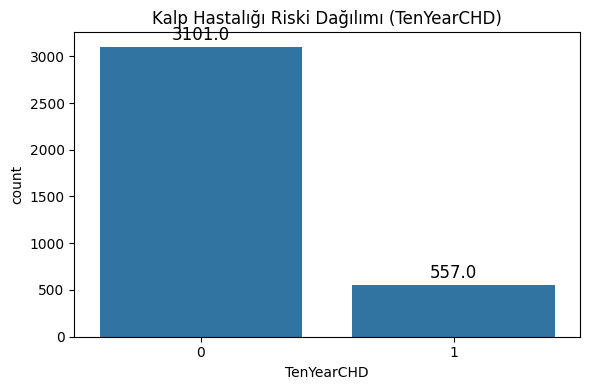

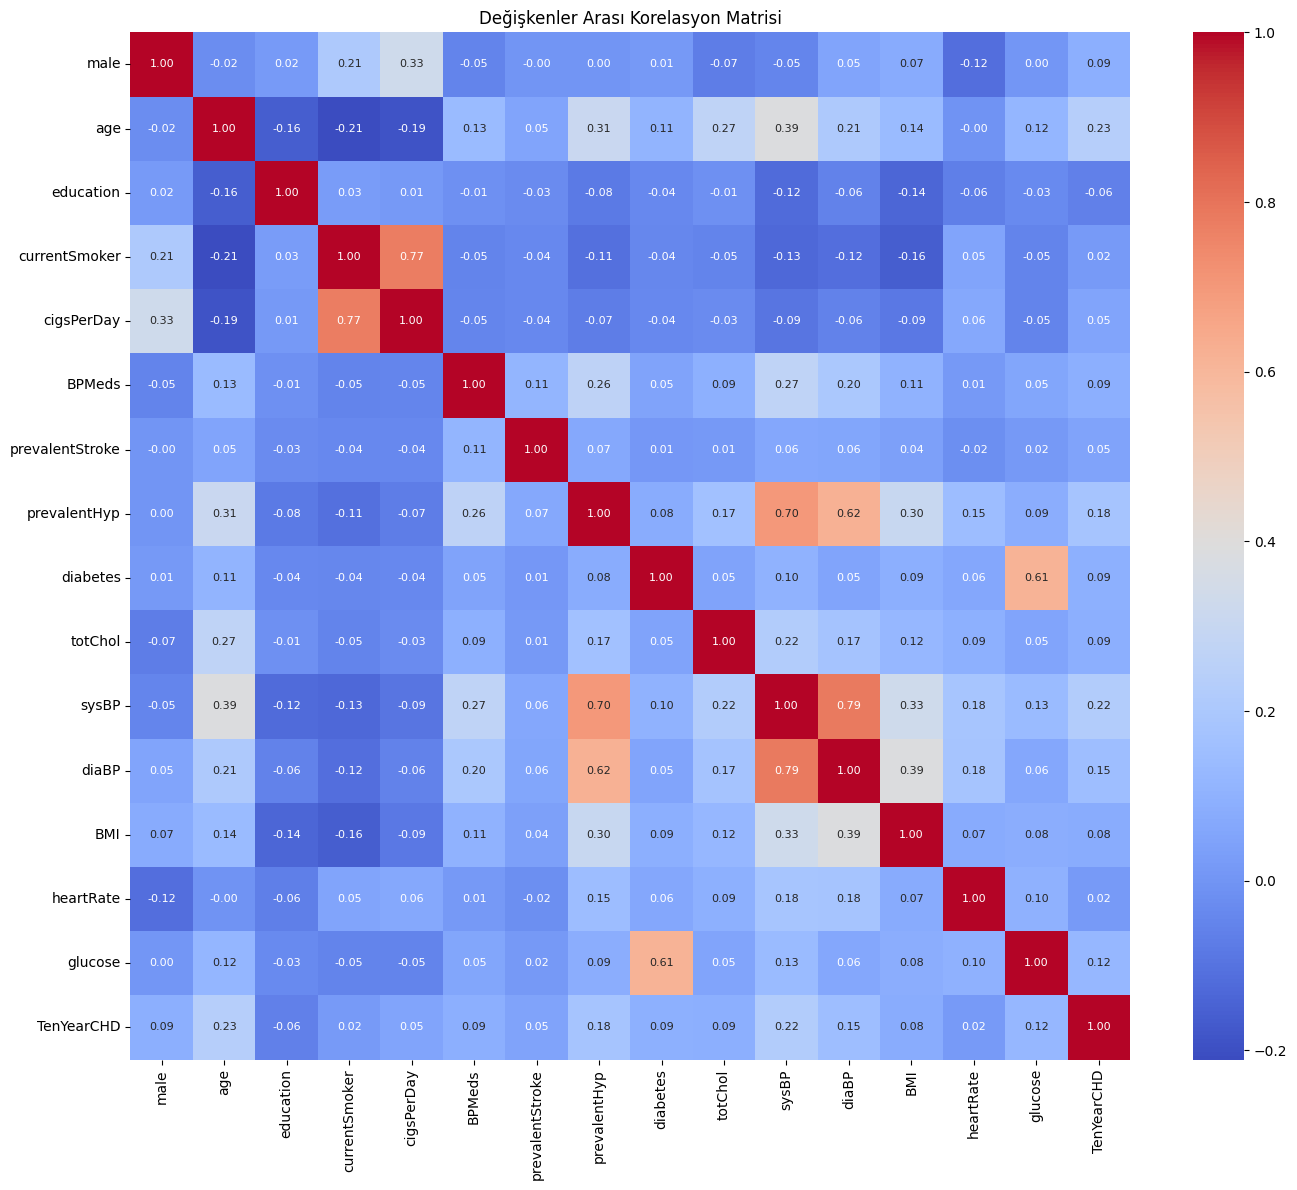

✅ Analiz görselleri 'SUNUM_MATERYALLERI' içine kaydedildi.


In [7]:
print("### 1. DESCRIPTIVE ANALYSIS GÖRSELLERİ HAZIRLANIYOR... ###")

# 1. Hedef Değişken Dağılımı Grafiği
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=TARGET_COL, data=df)
plt.title(f'Kalp Hastalığı Riski Dağılımı ({TARGET_COL})')

# Barların üzerine sayıları yazalım
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.savefig(f'{output_folder}/1_Hedef_Degisken_Dagilimi.png', dpi=300)
plt.show() 

# 2. Korelasyon Matrisi Grafiği
plt.figure(figsize=(14, 12)) # Değişken çok olduğu için büyüttüm
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})
plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.tight_layout()
plt.savefig(f'{output_folder}/2_Korelasyon_Matrisi.png', dpi=300)
plt.show()

# 3. İstatistiksel Tablo (Excel'e Kayıt)
desc_stats = df.describe().T
desc_stats.to_excel(f'{output_folder}/Tablo_Descriptive_Stats.xlsx')

print(f"✅ Analiz görselleri '{output_folder}' içine kaydedildi.")

In [8]:
# HEDEF VE ÖZELLİKLERİ AYIRMA
X = df.drop(TARGET_COL, axis=1) # TenYearCHD hariç hepsi
y = df[TARGET_COL]              # Sadece TenYearCHD

# Scaling (Neural Network için verileri standartlaştırıyoruz)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# MODELLER
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results_log = []

# Metrik Hesaplama Fonksiyonu
def get_metrics(y_true, y_pred, model_name, scenario):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try: auc = roc_auc_score(y_true, y_pred)
    except: auc = 0
    return {"Model": model_name, "Scenario": scenario, "Accuracy": acc, "Precision": prec, 
            "Recall": rec, "F1 Score": f1, "ROC AUC": auc, "y_true": y_true, "y_pred": y_pred}

print("✅ Veriler scale edildi ve modeller hazırlandı.")

✅ Veriler scale edildi ve modeller hazırlandı.


In [9]:
print("### 9 FARKLI SENARYO EĞİTİLİYOR... LÜTFEN BEKLEYİN ###")
step_counter = 1 

# --- YÖNTEM 1: Standart Split ---
print(f"\n--- YÖNTEM 1: Standart Split (%70 Train - %30 Test) ---")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

for name, model in models.items():
    print(f"⏳ Adım {step_counter}/9: {name} eğitiliyor...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results_log.append(get_metrics(y_test, preds, name, "1. Standart Split"))
    step_counter += 1

# --- YÖNTEM 2 & 3 İÇİN CROSS VALIDATION HAZIRLIĞI ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- YÖNTEM 2: K-Fold Only ---
print(f"\n--- YÖNTEM 2: K-Fold Only ---")
for name, model in models.items():
    print(f"⏳ Adım {step_counter}/9: {name} eğitiliyor (K-Fold)...")
    preds = cross_val_predict(model, X_scaled, y, cv=cv)
    results_log.append(get_metrics(y, preds, name, "2. K-Fold Only"))
    step_counter += 1

# --- YÖNTEM 3: SMOTE + K-Fold ---
print(f"\n--- YÖNTEM 3: SMOTE + K-Fold (Dengesiz Veri Çözümü) ---")
for name, model in models.items():
    print(f"⏳ Adım {step_counter}/9: {name} eğitiliyor (SMOTE)...")
    # Pipeline: Her fold içinde önce SMOTE uygular, sonra modeli eğitir.
    pipeline = ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('model', model)])
    preds = cross_val_predict(pipeline, X_scaled, y, cv=cv)
    results_log.append(get_metrics(y, preds, name, "3. SMOTE + K-Fold"))
    step_counter += 1

print("\n✅ TÜM EĞİTİMLER TAMAMLANDI.")

### 9 FARKLI SENARYO EĞİTİLİYOR... LÜTFEN BEKLEYİN ###

--- YÖNTEM 1: Standart Split (%70 Train - %30 Test) ---
⏳ Adım 1/9: Random Forest eğitiliyor...
⏳ Adım 2/9: XGBoost eğitiliyor...
⏳ Adım 3/9: Neural Network eğitiliyor...

--- YÖNTEM 2: K-Fold Only ---
⏳ Adım 4/9: Random Forest eğitiliyor (K-Fold)...
⏳ Adım 5/9: XGBoost eğitiliyor (K-Fold)...
⏳ Adım 6/9: Neural Network eğitiliyor (K-Fold)...

--- YÖNTEM 3: SMOTE + K-Fold (Dengesiz Veri Çözümü) ---
⏳ Adım 7/9: Random Forest eğitiliyor (SMOTE)...
⏳ Adım 8/9: XGBoost eğitiliyor (SMOTE)...
⏳ Adım 9/9: Neural Network eğitiliyor (SMOTE)...

✅ TÜM EĞİTİMLER TAMAMLANDI.


### SONUÇ TABLOSU ###


,Model,Scenario,Accuracy,Precision,Recall,F1 Score,ROC AUC
6,Random Forest,3. SMOTE + K-Fold,0.759158,0.290155,0.402154,0.337096,0.612719
8,Neural Network,3. SMOTE + K-Fold,0.763805,0.261275,0.301616,0.280000,0.574220
5,Neural Network,2. K-Fold Only,0.789776,0.267544,0.219031,0.240869,0.555662
2,Neural Network,1. Standart Split,0.791439,0.261538,0.203593,0.228956,0.550239
7,XGBoost,3. SMOTE + K-Fold,0.804811,0.284932,0.186715,0.225597,0.551274
4,XGBoost,2. K-Fold Only,0.834609,0.386792,0.147217,0.213264,0.552648
1,XGBoost,1. Standart Split,0.833333,0.370968,0.137725,0.200873,0.547917
0,Random Forest,1. Standart Split,0.851548,0.666667,0.047904,0.089385,0.521804
3,Random Forest,2. K-Fold Only,0.846364,0.450980,0.041293,0.075658,0.516132


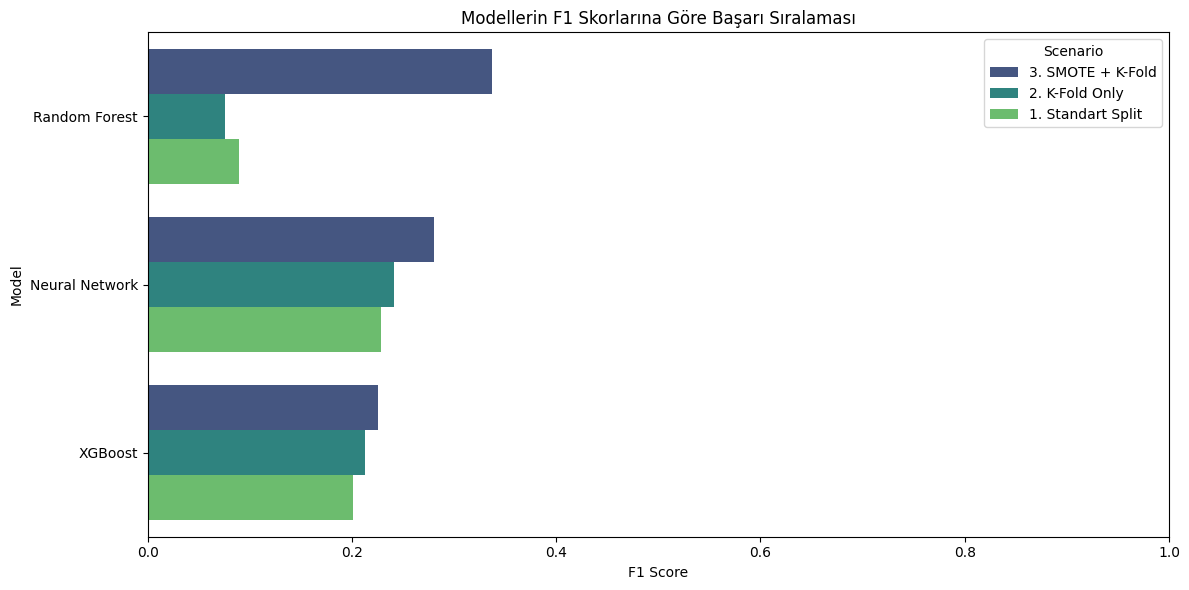

✅ Tablo ve karşılaştırma grafiği kaydedildi.


In [10]:
results_df = pd.DataFrame(results_log)
display_cols = ["Model", "Scenario", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

# F1 Score'a göre sırala (En iyi en üstte)
final_table = results_df[display_cols].sort_values(by="F1 Score", ascending=False)

print("### SONUÇ TABLOSU ###")
display(final_table)
final_table.to_excel(f'{output_folder}/Tablo_Model_Karsilastirma.xlsx', index=False)

# Grafik: F1 Score Karşılaştırması
plt.figure(figsize=(12, 6))
sns.barplot(x="F1 Score", y="Model", hue="Scenario", data=final_table, palette="viridis")
plt.title("Modellerin F1 Skorlarına Göre Başarı Sıralaması")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.savefig(f'{output_folder}/3_F1_Score_Karsilastirma.png', dpi=300)
plt.show()

print("✅ Tablo ve karşılaştırma grafiği kaydedildi.")

### 9 SENARYONUN CONFUSION MATRIX GÖRÜNTÜSÜ ###


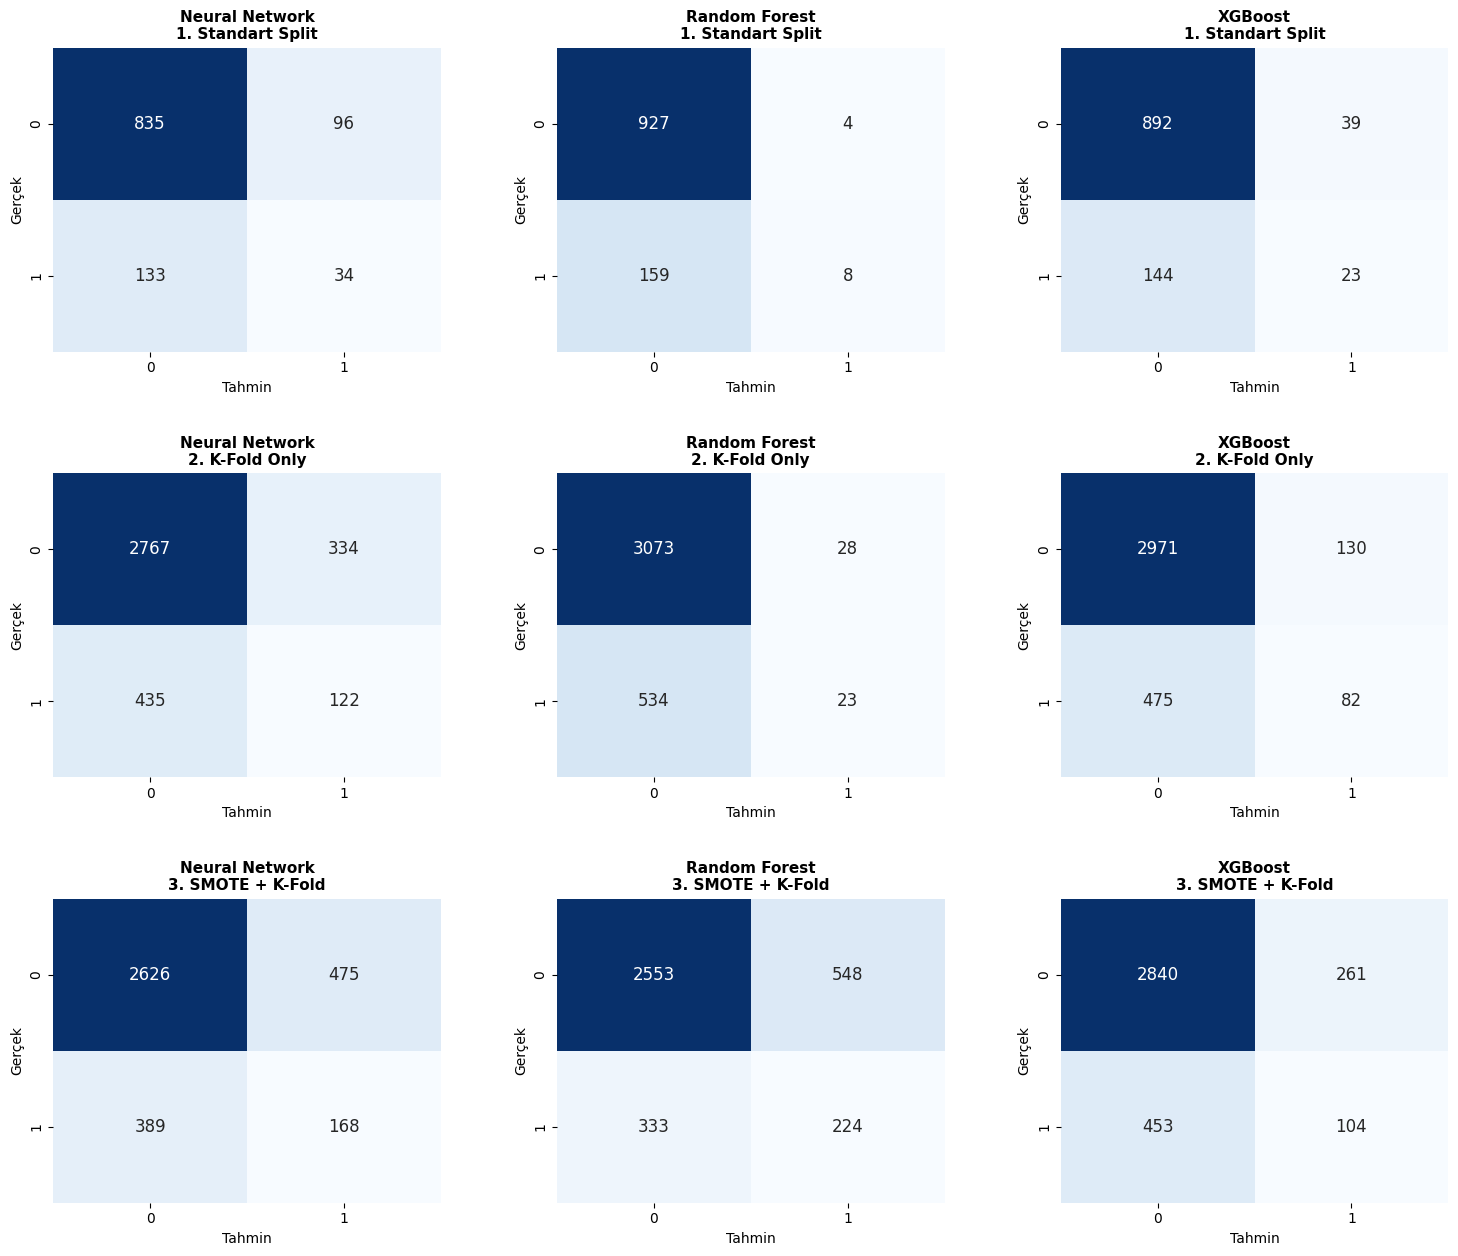

In [11]:
# Görselleştirme için sıralamayı düzenle
results_df['Scenario_Order'] = results_df['Scenario'].apply(lambda x: int(x[0]))
viz_df = results_df.sort_values(by=['Scenario_Order', 'Model'])

print("### 9 SENARYONUN CONFUSION MATRIX GÖRÜNTÜSÜ ###")

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, (index, row) in enumerate(viz_df.iterrows()):
    ax = axes[i // 3, i % 3]
    cm = confusion_matrix(row['y_true'], row['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, annot_kws={"size": 12})
    
    ax.set_title(f"{row['Model']}\n{row['Scenario']}", fontsize=11, fontweight='bold')
    ax.set_xlabel("Tahmin")
    ax.set_ylabel("Gerçek")

plt.savefig(f'{output_folder}/4_Tum_Senaryolar_Matrix.png', dpi=300)
plt.show()

🏆 ŞAMPİYON MODEL: Random Forest (3. SMOTE + K-Fold)
F1 Skoru: 0.3371


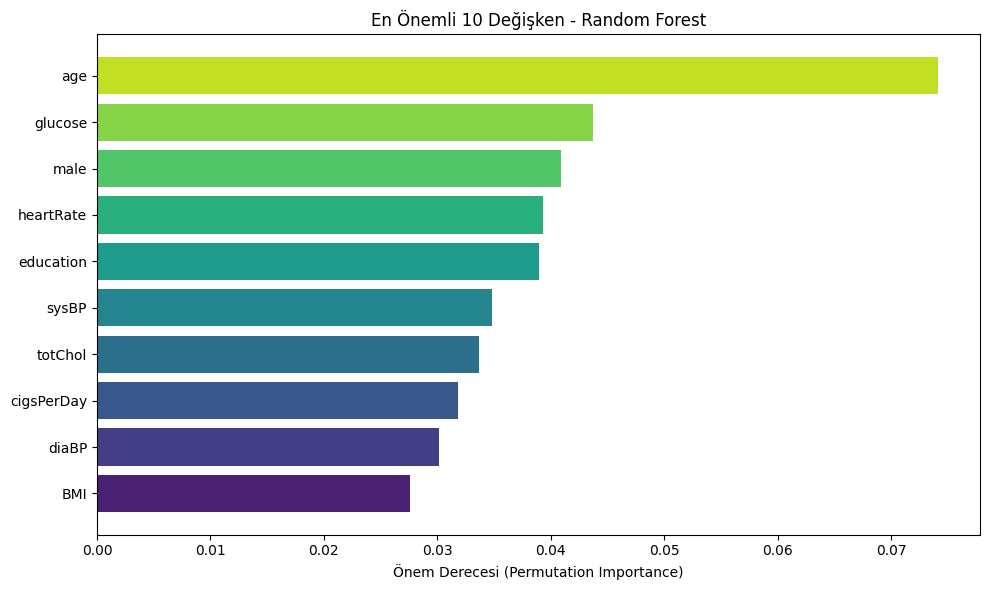

✅ Tüm işlemler bitti. 'SUNUM_MATERYALLERI' klasörünü kontrol edebilirsin.


In [12]:
# En iyi modeli seç
best_result = results_df.loc[results_df['F1 Score'].idxmax()]
best_model_name = best_result['Model']
best_scenario = best_result['Scenario']

print(f"🏆 ŞAMPİYON MODEL: {best_model_name} ({best_scenario})")
print(f"F1 Skoru: {best_result['F1 Score']:.4f}")

# Şampiyon modeli son kez eğitiyoruz (Özellik önemlerini çıkarmak için)
final_model = models[best_model_name]

if "SMOTE" in best_scenario:
    sampler = SMOTE(random_state=42)
    X_final, y_final = sampler.fit_resample(X_scaled, y)
    final_model.fit(X_final, y_final)
else:
    final_model.fit(X_scaled, y)

# Özellik Önem Derecelerini Hesapla
perm_importance = permutation_importance(final_model, X_scaled, y, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-10:] # En önemli 10 özellik

# Grafiği Çiz
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", n_colors=10)
# X.columns sayesinde artık 'feature_0' yerine 'age', 'BMI' gibi gerçek isimler göreceksin
plt.barh(range(10), perm_importance.importances_mean[sorted_idx], align='center', color=colors)
plt.yticks(range(10), np.array(X.columns)[sorted_idx]) 
plt.xlabel("Önem Derecesi (Permutation Importance)")
plt.title(f"En Önemli 10 Değişken - {best_model_name}")
plt.tight_layout()
plt.savefig(f'{output_folder}/5_Feature_Importance.png', dpi=300)
plt.show()

print("✅ Tüm işlemler bitti. 'SUNUM_MATERYALLERI' klasörünü kontrol edebilirsin.")